### Causal Argumentation Method

Version 1

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import pydot

from causallearn.utils.cit import fisherz
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.Endpoint import Endpoint
from causallearn.utils.GraphUtils import GraphUtils

Helper methods

In [2]:

def _unwrap_graph(result):
    try:
        return result.G
    except Exception:
        return result[0] if isinstance(result, (list, tuple)) else result

def _ensure_numeric(df: pd.DataFrame, cols):
    out = {}
    for c in cols:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            out[c] = s
        else:
            codes, _ = pd.factorize(s, sort=True)
            out[c] = pd.Series(codes, index=s.index)
    return pd.DataFrame(out)

def force_sink(graph, sink_name: str):
    sink = graph.get_node(sink_name)
    if sink is None:
        raise ValueError(f"'{sink_name}' not found in graph")
    neighbors = list(graph.get_adjacent_nodes(sink))
    for nb in neighbors:
        for method in [
            lambda: graph.remove_edge(graph.get_edge(sink, nb)),
            lambda: graph.remove_edge(graph.get_edge(nb, sink)),
            lambda: graph.remove_edge_between(sink, nb)
        ]:
            try:
                method()
            except Exception:
                pass
        try:
            graph.add_directed_edge(nb, sink)
        except Exception:
            graph.add_edge(nb, sink, Endpoint.TAIL, Endpoint.ARROW)

Data Clustering methods

In [3]:
def _entropy(p):
    if p <= 0.0 or p >= 1.0:
        return 0.0
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

def _segment_entropy(y):
    y = np.asarray(y).astype(int)
    if len(y) == 0:
        return 0.0
    return _entropy(y.mean())

def _info_gain(y_parent, y_left, y_right):
    H_parent = _segment_entropy(y_parent)
    n = len(y_parent)
    wL = len(y_left) / n
    wR = len(y_right) / n
    return H_parent - (wL * _segment_entropy(y_left) + wR * _segment_entropy(y_right))

def _best_threshold_1d(x, y, min_bin_size=20):
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    uniq = np.unique(x_sorted)
    if len(uniq) <= 1:
        return 0.0, None
    best_gain, best_thr = 0.0, None
    n = len(x_sorted)
    for i in range(min_bin_size, n - min_bin_size + 1):
        if x_sorted[i - 1] == x_sorted[i]:
            continue
        thr = (x_sorted[i - 1] + x_sorted[i]) / 2.0
        yL = y_sorted[:i]
        yR = y_sorted[i:]
        gain = _info_gain(y_sorted, yL, yR)
        if gain > best_gain:
            best_gain, best_thr = gain, thr
    return best_gain, best_thr

def _recursive_entropy_splits(x, y, max_bins=4, min_gain=0.005, min_bin_size=20):
    gain, thr = _best_threshold_1d(x, y, min_bin_size=min_bin_size)
    if thr is None or gain < min_gain or max_bins <= 1:
        return []
    left_idx = x <= thr
    right_idx = ~left_idx
    left_splits = _recursive_entropy_splits(
        x[left_idx], y[left_idx], max_bins=max_bins - 1, min_gain=min_gain, min_bin_size=min_bin_size
    )
    right_splits = _recursive_entropy_splits(
        x[right_idx], y[right_idx], max_bins=max_bins - 1, min_gain=min_gain, min_bin_size=min_bin_size
    )
    return sorted(left_splits + [thr] + right_splits)

def entropy_binning(series: pd.Series, y_binary: pd.Series,
                    max_bins=4, min_gain=0.005, min_bin_size=20):
    s_notna = series.dropna()
    if s_notna.empty:
        return [-np.inf, np.inf], [f"{series.name}:(all)"]
    s = s_notna.to_numpy(dtype=float)
    y = y_binary.loc[s_notna.index]
    if not pd.api.types.is_numeric_dtype(y):
        y = pd.Categorical(y).codes
    y = y.to_numpy(dtype=int)

    thresholds = _recursive_entropy_splits(
        s, y, max_bins=max_bins, min_gain=min_gain, min_bin_size=min_bin_size
    )
    if not thresholds:
        return [-np.inf, np.inf], [f"{series.name}:(all)"]
    edges = [-np.inf] + sorted(thresholds) + [np.inf]
    labels = [f"{series.name}[{edges[i]:.3f},{edges[i+1]:.3f})" for i in range(len(edges) - 1)]
    return edges, labels

STEP 1 - Causal Discovery

_run_discovery(df, features, outcome, alpha, categorical_features,
               entropy_binning_config, binarize_counts, baseline_strategy)


In [ ]:
def _prepare_discovery_encoding(
    df, features, outcome,
    categorical_features=None,
    entropy_binning_config=None,
    binarize_counts=None,
    baseline_strategy="drop_first"
):
    """
    Encode data for causal discovery (PC/FCI) run.
    - df: full DataFrame
    - features: list of predictor columns
    - outcome: outcome/target column name
    - categorical_features: optional list; if None, auto-detect non-numeric
    - entropy_binning_config: dict, e.g. {'features': ['age'], 'max_bins':4,...}
    - binarize_counts: iterable of features to binarize (e.g. ['sibsp','parch'])
    - baseline_strategy: 'drop_first' or 'drop_last'
    """
    if categorical_features is None:
        categorical_features = [f for f in features if not pd.api.types.is_numeric_dtype(df[f])]

    bin_feats = set()
    bin_params = dict(max_bins=4, min_gain=0.005, min_bin_size=20)
    if entropy_binning_config:
        bin_feats = set(entropy_binning_config.get("features", []))
        for k in ("max_bins", "min_gain", "min_bin_size"):
            if k in entropy_binning_config:
                bin_params[k] = entropy_binning_config[k]

    y_bin = df[outcome] if pd.api.types.is_numeric_dtype(df[outcome]) else pd.Categorical(df[outcome]).codes
    y_bin = pd.Series(y_bin, index=df.index, name=outcome)

    df_processed = pd.DataFrame(index=df.index)
    encoding_groups = {}

    # 1) Entropy-binned numeric features
    for feat in features:
        if feat in bin_feats and pd.api.types.is_numeric_dtype(df[feat]):
            edges, labels = entropy_binning(
                df[feat], y_bin,
                max_bins=bin_params["max_bins"],
                min_gain=bin_params["min_gain"],
                min_bin_size=bin_params["min_bin_size"]
            )
            binned = pd.cut(df[feat], bins=edges, labels=labels, include_lowest=True)
            dummies = pd.get_dummies(binned, prefix="", prefix_sep="", drop_first=True)
            encoding_groups[feat] = list(dummies.columns)
            df_processed = pd.concat([df_processed, dummies], axis=1)

    # 2) Numeric features 
    for feat in features:
        if feat not in categorical_features and feat not in bin_feats:
            if binarize_counts and feat in binarize_counts:
                df_processed[feat] = (df[feat].fillna(0) > 0).astype(int)
            else:
                df_processed[feat] = df[feat]

    # 3) Categorical one-hots
    for cat_feat in categorical_features:
        if baseline_strategy == "drop_last":
            d_all = pd.get_dummies(df[cat_feat], prefix=cat_feat, drop_first=False)
            keep = sorted(d_all.columns)[:-1]
            dummies = d_all[keep]
        else:
            dummies = pd.get_dummies(df[cat_feat], prefix=cat_feat, drop_first=True)
        encoding_groups[cat_feat] = list(dummies.columns)
        df_processed = pd.concat([df_processed, dummies], axis=1)

    df_processed[outcome] = df[outcome]
    return df_processed.to_numpy(), list(df_processed.columns), df_processed, encoding_groups


def _prepare_unified_encoding(
    df, features, outcome,
    categorical_features=None,
    entropy_binning_config=None,
    binarize_counts=None,
    dummy_noise=0.0
):
    """
    Encode for the final unified graph (keeps *all* bins/dummies).
    """
    if categorical_features is None:
        categorical_features = [f for f in features if not pd.api.types.is_numeric_dtype(df[f])]

    bin_feats = set()
    bin_params = dict(max_bins=4, min_gain=0.005, min_bin_size=20)
    if entropy_binning_config:
        bin_feats = set(entropy_binning_config.get("features", []))
        for k in ("max_bins", "min_gain", "min_bin_size"):
            if k in entropy_binning_config:
                bin_params[k] = entropy_binning_config[k]

    y_bin = df[outcome] if pd.api.types.is_numeric_dtype(df[outcome]) else pd.Categorical(df[outcome]).codes
    y_bin = pd.Series(y_bin, index=df.index, name=outcome)

    dfU = pd.DataFrame(index=df.index)
    enc_groups_full = {}

    # 1) Entropy-binned numeric features
    for feat in features:
        if feat in bin_feats and pd.api.types.is_numeric_dtype(df[feat]):
            edges, labels = entropy_binning(
                df[feat], y_bin,
                max_bins=bin_params["max_bins"],
                min_gain=bin_params["min_gain"],
                min_bin_size=bin_params["min_bin_size"]
            )
            binned = pd.cut(df[feat], bins=edges, labels=labels, include_lowest=True)
            dummies = pd.get_dummies(binned, prefix="", prefix_sep="", drop_first=False)
            enc_groups_full[feat] = list(dummies.columns)
            dfU = pd.concat([dfU, dummies], axis=1)

    # 2) Numeric features (optionally binarize)
    for feat in features:
        if feat not in categorical_features and feat not in bin_feats:
            if binarize_counts and feat in binarize_counts:
                dfU[feat] = (df[feat].fillna(0) > 0).astype(int)
                enc_groups_full.setdefault(feat, [feat])
            else:
                dfU[feat] = df[feat]

    # 3) Categorical features (keep all)
    for cat_feat in categorical_features:
        dummies = pd.get_dummies(df[cat_feat], prefix=cat_feat, drop_first=False)
        enc_groups_full[cat_feat] = list(dummies.columns)
        dfU = pd.concat([dfU, dummies], axis=1)

    dfU[outcome] = df[outcome]
    return dfU, enc_groups_full


Step 1.2 : run discovery twice, merge group-level edges, build unified encoded graph

In [5]:

def _run_discovery(df, features, outcome, alpha, categorical_features,
                   entropy_binning_config, binarize_counts, baseline_strategy,
                   algo="pc"):
    data, col_names, df_processed, encoding_groups = _prepare_discovery_encoding(
        df, features, outcome, categorical_features,
        entropy_binning_config, binarize_counts, baseline_strategy
    )
    if algo.lower() == "pc":
        res = pc(data, alpha=alpha, ci_test=fisherz, node_names=col_names)
    else:
        res = fci(data, alpha=alpha, ci_test=fisherz, node_names=col_names)
    graph = _unwrap_graph(res)
    force_sink(graph, outcome)

    if hasattr(res, '__dict__'):
        res._processed_df = df_processed
        res._encoding_groups = encoding_groups
    else:
        class ResultWrapper:
            def __init__(self, original, dfp, groups):
                self.G = _unwrap_graph(original)
                self._processed_df = dfp
                self._encoding_groups = groups
        res = ResultWrapper(res, df_processed, encoding_groups)
    return res

def _column_to_group_map(encoding_groups, features, outcome):
    col2group = {}
    for g, cols in (encoding_groups or {}).items():
        for c in cols:
            col2group[c] = g
    for g in features + [outcome]:
        col2group.setdefault(g, g)
    return col2group

def _extract_group_edges(cg_result, features, outcome):
    G = _unwrap_graph(cg_result)
    groups = getattr(cg_result, '_encoding_groups', {})
    col2group = _column_to_group_map(groups, features, outcome)
    group_edges = set()
    for n in G.get_nodes():
        for ch in G.get_children(n):
            src = col2group.get(n.get_name(), n.get_name())
            dst = col2group.get(ch.get_name(), ch.get_name())
            if src != dst:
                group_edges.add((src, dst))
    return group_edges

def merge_orientations(edges1, edges2, rule="majority"):
    dir_counts = {}
    for (a, b) in edges1:
        dir_counts[(a, b)] = dir_counts.get((a, b), 0) + 1
    for (a, b) in edges2:
        dir_counts[(a, b)] = dir_counts.get((a, b), 0) + 1

    merged = {}
    nodes = set([a for a, _ in dir_counts] + [b for _, b in dir_counts])
    pairs = set()
    for a in nodes:
        for b in nodes:
            if a < b:
                pairs.add((a, b))
    for a, b in pairs:
        ab = dir_counts.get((a, b), 0)
        ba = dir_counts.get((b, a), 0)
        if rule == "intersection":
            if ab == 2:
                merged[(a, b)] = 1
            if ba == 2:
                merged[(b, a)] = 1
        elif rule == "union":
            if ab > 0:
                merged[(a, b)] = 1
            if ba > 0:
                merged[(b, a)] = 1
        else:  # majority
            if ab > ba and ab > 0:
                merged[(a, b)] = 1
            if ba > ab and ba > 0:
                merged[(b, a)] = 1
    return set(merged.keys())

class _SimpleNode:
    def __init__(self, name):
        self._n = name
    def get_name(self):
        return self._n

class _SimpleGraph:
    def __init__(self, edges, nodes):
        self._nodes = {n: _SimpleNode(n) for n in nodes}
        self._children = {n: set() for n in nodes}
        for a, b in edges:
            if a in self._nodes and b in self._nodes and a != b:
                self._children[a].add(b)
    def get_nodes(self):
        return list(self._nodes.values())
    def get_children(self, node):
        return [self._nodes[c] for c in self._children.get(node.get_name(), [])]
    def get_node(self, name):
        return self._nodes.get(name, None)

class _ResultShim:
    def __init__(self, edges, nodes, df_processed, encoding_groups):
        self.G = _SimpleGraph(edges, nodes)
        self._processed_df = df_processed
        self._encoding_groups = encoding_groups

def run_dual_and_merge_with_unified(df, features, outcome, categorical_features,
                                    entropy_binning_config=None, binarize_counts=('sibsp', 'parch'),
                                    algo="pc", alpha=0.01, merge_rule="majority",
                                    unified_dummy_noise=0.0):
    run1 = _run_discovery(df, features, outcome, alpha, categorical_features,
                          entropy_binning_config, binarize_counts, "drop_first", algo=algo)
    run2 = _run_discovery(df, features, outcome, alpha, categorical_features,
                          entropy_binning_config, binarize_counts, "drop_last", algo=algo)

    g1 = _extract_group_edges(run1, features, outcome)
    g2 = _extract_group_edges(run2, features, outcome)
    merged_group_edges = merge_orientations(g1, g2, rule=merge_rule)

    dfU, enc_groups_full = _prepare_unified_encoding(
        df, features, outcome, categorical_features,
        entropy_binning_config, binarize_counts, dummy_noise=unified_dummy_noise
    )

    encoded_nodes = list(dfU.columns)

    def group_cols(g):
        return enc_groups_full.get(g, [g])

    final_edges = []
    for (gA, gB) in merged_group_edges:
        for a in group_cols(gA):
            for b in group_cols(gB):
                if a != b:
                    final_edges.append((a, b))

    merged_result = _ResultShim(final_edges, encoded_nodes, dfU, enc_groups_full)
    return merged_result, merged_group_edges, dfU, enc_groups_full, run1, run2


Step 3: Unified graphs

In [6]:
def _edge_style_from_r(edge_obj, r, same_group=False):
    if same_group:
        edge_obj.set_style("dotted")
        edge_obj.set_color("#c62828")
    else:
        col = "#2e7d32" if r >= 0 else "#c62828"
        edge_obj.set_color(col)
        if abs(r) < 0.10:
            edge_obj.set_style("dashed")
    edge_obj.set_penwidth(str(1.0 + 4.0 * min(abs(r), 1.0)))

def export_causallearn_graph_with_corr(res, filename: str):
    G = _unwrap_graph(res)
    names = [n.get_name() for n in G.get_nodes()]
    df_for_corr = getattr(res, "_processed_df", None)
    if df_for_corr is None:
        raise ValueError("Result missing _processed_df for correlation labeling.")
    enc_groups = getattr(res, "_encoding_groups", {})
    col_to_group = {c: g for g, cols in enc_groups.items() for c in cols}

    df_num = _ensure_numeric(df_for_corr, names)
    corr = df_num.corr(method="pearson")

    idx_to_name = {str(i): name for i, name in enumerate(names)}
    dot = GraphUtils.to_pydot(G)
    for edge in dot.get_edges():
        src_idx = str(edge.get_source()).strip('"').strip()
        dst_idx = str(edge.get_destination()).strip('"').strip()
        src = idx_to_name.get(src_idx, src_idx)
        dst = idx_to_name.get(dst_idx, dst_idx)

        same_group = (col_to_group.get(src) is not None and
                      col_to_group.get(src) == col_to_group.get(dst))
        if same_group:
            r = -1.0
        else:
            r = np.nan
            if src in corr.index and dst in corr.columns:
                r = float(corr.loc[src, dst])
            elif dst in corr.index and src in corr.columns:
                r = float(corr.loc[dst, src])

        if not pd.isna(r):
            edge.set_label(f" {r:+.3f} ")
            edge.set_fontsize("11")
            _edge_style_from_r(edge, r, same_group=same_group)

    dot.write_png(filename)
    print(f"Saved (corr-labeled): {filename}")

def export_unified_graph_with_corr(merged_result, filename: str, title="Unified Encoded Graph"):
    G = merged_result.G
    nodes = [n.get_name() for n in G.get_nodes()]
    df_for_corr = getattr(merged_result, "_processed_df", None)
    if df_for_corr is None:
        raise ValueError("merged_result missing _processed_df for correlation labeling.")
    enc_groups = getattr(merged_result, "_encoding_groups", {})
    col_to_group = {c: g for g, cols in enc_groups.items() for c in cols}

    df_num = _ensure_numeric(df_for_corr, nodes)
    corr = df_num.corr(method="pearson")

    graph = pydot.Dot(graph_type='digraph', rankdir='LR', label=title, labelloc='t', fontsize='20')
    pd_nodes = {n: pydot.Node(n, shape='ellipse', fontsize='10') for n in nodes}
    for n, node in pd_nodes.items():
        graph.add_node(node)

    for n in G.get_nodes():
        for ch in G.get_children(n):
            a, b = n.get_name(), ch.get_name()
            same_group = (col_to_group.get(a) is not None and col_to_group.get(a) == col_to_group.get(b))
            if same_group:
                r = -1.0
            else:
                r = np.nan
                if a in corr.index and b in corr.columns:
                    r = float(corr.loc[a, b])
                elif b in corr.index and a in corr.columns:
                    r = float(corr.loc[b, a])
            e = pydot.Edge(pd_nodes[a], pd_nodes[b], arrowsize='0.8')
            if not pd.isna(r):
                e.set_label(f" {r:+.3f} ")
                e.set_fontsize("11")
                _edge_style_from_r(e, r, same_group=same_group)
            graph.add_edge(e)

    graph.write_png(filename)
    print(f"Saved (corr-labeled): {filename}")

def export_group_graph_with_corr(group_edges, df_unified, enc_groups_full, filename: str,
                                 title="Merged Group Graph (corr = strongest pair)"):
    def members(g):
        return enc_groups_full.get(g, [g])

    nodesU = df_unified.columns.tolist()
    df_num = _ensure_numeric(df_unified, nodesU)
    corr = df_num.corr(method="pearson")

    nodes = sorted(set([a for a, _ in group_edges] + [b for _, b in group_edges]))
    graph = pydot.Dot(graph_type='digraph', rankdir='LR', label=title, labelloc='t', fontsize='20')
    pd_nodes = {n: pydot.Node(n, shape='box', style='rounded,filled', fillcolor='#eef5ff') for n in nodes}
    for n, node in pd_nodes.items():
        graph.add_node(node)

    for gA, gB in group_edges:
        best_r = 0.0
        best_pair = None
        for a in members(gA):
            for b in members(gB):
                if a not in corr.index or b not in corr.columns:
                    continue
                r = corr.loc[a, b]
                if pd.isna(r):
                    continue
                if abs(r) > abs(best_r):
                    best_r = r
                    best_pair = (a, b)
        e = pydot.Edge(pd_nodes[gA], pd_nodes[gB], arrowsize='0.9')
        if best_pair is not None:
            e.set_label(f" {best_r:+.3f} ")
            e.set_fontsize("11")
            _edge_style_from_r(e, float(best_r), same_group=False)
        else:
            e.set_style("dashed")
            e.set_color("#9e9e9e")
        graph.add_edge(e)

    graph.write_png(filename)
    print(f"Saved (corr-labeled): {filename}")


Step: BAF and AF (with fixed generate_constellations + grounded)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations


class BAF:
    def __init__(self, result, df=None):
        graph = _unwrap_graph(result)
        self.arguments = [n.get_name() for n in graph.get_nodes()]

        # Choose dataframe for correlations
        if hasattr(result, '_processed_df'):
            df_for_corr = result._processed_df
        else:
            if df is None:
                raise ValueError("Must provide df")
            df_for_corr = df

        # Encoding groups (for one-hot / bins)
        self.encoding_groups = getattr(result, '_encoding_groups', {})
        self.col_to_group = {
            c: g for g, cols in self.encoding_groups.items() for c in cols
        }

        # Correlation matrix over arguments
        df_num = _ensure_numeric(df_for_corr, self.arguments)
        self.corr_matrix = df_num.corr(method="pearson")

        # Build supports and attacks
        self.supports, self.attacks = {}, {}
        for node in graph.get_nodes():
            for child in graph.get_children(node):
                src = node.get_name()
                dst = child.get_name()
                r = self._get_correlation(src, dst)
                if not pd.isna(r):
                    if r > 0:
                        self.supports[(src, dst)] = r
                    else:
                        self.attacks[(src, dst)] = abs(r)

    def _get_correlation(self, src, dst):
        # Force strong attack within same encoding group
        g1 = self.col_to_group.get(src)
        g2 = self.col_to_group.get(dst)
        if g1 is not None and g2 is not None and g1 == g2:
            return -1.0
        try:
            return self.corr_matrix.loc[src, dst]
        except Exception:
            try:
                return self.corr_matrix.loc[dst, src]
            except Exception:
                return np.nan

    def to_classical_af(self, threshold=0.0, verbose=False,
                        enforce_exclusivity=True,
                        exclusivity_skip=('survived',),
                        exclusivity_weight=1.0):
        af_attacks = self.attacks.copy()
        working_supports = self.supports.copy()

        # ========= SUPPORT CLOSURE (A→B, B→C ⇒ A→C) =========
        changed = True
        while changed:
            changed = False
            for (A, B), x in list(working_supports.items()):
                for (B2, C), y in list(working_supports.items()):
                    if B == B2 and A != C:
                        new_weight = x * y
                        if new_weight > threshold:
                            if (A, C) not in working_supports or working_supports[(A, C)] < new_weight:
                                working_supports[(A, C)] = new_weight
                                changed = True

        # ========= SUPPORT → ATTACK (A→B, B↛C ⇒ A↛C) =========
        for (A, B), x in working_supports.items():
            for (B2, C), y in list(af_attacks.items()):
                if B == B2 and A != C:
                    new_weight = x * y
                    if new_weight > threshold and (A, C) not in af_attacks:
                        af_attacks[(A, C)] = new_weight

        # ========= ATTACK → COUNTERATTACK VIA SUPPORT =========
        for (A, B), x in list(af_attacks.items()):
            for (C, B2), y in working_supports.items():
                if B == B2 and A != C:
                    new_weight = y
                    if new_weight > threshold and (C, A) not in af_attacks:
                        af_attacks[(C, A)] = new_weight

        af = AF(self.arguments, af_attacks)

        # Add mutual exclusivity for one-hot groups (except skips)
        if enforce_exclusivity and getattr(self, "encoding_groups", None):
            skip = set(exclusivity_skip or ())
            groups = {g: cols for g, cols in self.encoding_groups.items() if g not in skip}
            af.add_mutual_exclusivity(groups, weight=exclusivity_weight)

        return af


class AF:
    def __init__(self, arguments, attacks):
        self.arguments = list(arguments)
        self.attacks = dict(attacks)

 
    def print_summary(self):
        print(f"\nClassical AF Summary:")
        print(f"  Arguments: {len(self.arguments)}")
        print(f"  Attack relations: {len(self.attacks)}")

    def to_apx_format(self, filename="framework.apx"):
        with open(filename, 'w') as f:
            for arg in self.arguments:
                f.write(f"arg({arg}).\n")
            f.write("\n")
            for (src, tgt), _ in self.attacks.items():
                f.write(f"att({src},{tgt}).\n")
        print(f"Exported APX format to: {filename}")
        return filename

    def to_tgf_format(self, filename="framework.tgf"):
        with open(filename, 'w') as f:
            for arg in self.arguments:
                f.write(f"{arg}\n")
            f.write("#\n")
            for (src, tgt), _ in self.attacks.items():
                f.write(f"{src} {tgt}\n")
        print(f"Exported TGF format to: {filename}")
        return filename

    def add_mutual_exclusivity(self, groups: dict, weight: float = 1.0):
        for _, cols in groups.items():
            cols = [c for c in cols if c in self.arguments]
            for i in range(len(cols)):
                for j in range(i + 1, len(cols)):
                    a, b = cols[i], cols[j]
                    self.attacks[(a, b)] = max(weight, self.attacks.get((a, b), 0.0))
                    self.attacks[(b, a)] = max(weight, self.attacks.get((b, a), 0.0))

    # --------------------------------------------------------------
    # Dung helpers
    # --------------------------------------------------------------
    def _attacks(self, A, B):
        return (A, B) in self.attacks

    def _attackers_of(self, x):
        return {a for (a, b) in self.attacks if b == x}

    def _range_of(self, S):
        attacked = {b for (a, b) in self.attacks if a in S}
        return set(S) | attacked

    def _is_conflict_free(self, S):
        return all((a, b) not in self.attacks for a in S for b in S if a != b)

    def _defends(self, S, x):
        for a in self._attackers_of(x):
            if not any(self._attacks(b, a) for b in S):
                return False
        return True

    def _is_admissible(self, S):
        if not self._is_conflict_free(S):
            return False
        return all(self._defends(S, x) for x in S)

    def _all_admissible_sets(self, limit_nodes=22):
        U = list(self.arguments)
        n = len(U)
        if n > limit_nodes:
            k = max(10, min(14, n // 2))

            def k_subsets(iterable, kmax):
                it = list(iterable)
                for r in range(kmax + 1):
                    for comb in combinations(it, r):
                        yield set(comb)

            candidates = k_subsets(U, k)
        else:
            candidates = (set(c) for r in range(n + 1) for c in combinations(U, r))
        return [S for S in candidates if self._is_admissible(S)]

    def semistable_extensions(self):
        adm = self._all_admissible_sets()
        if not adm:
            return []
        ranges = [(S, len(self._range_of(S))) for S in adm]
        max_range = max(sz for _, sz in ranges)
        return [S for S, sz in ranges if sz == max_range]

    def compute_grounded_extension(self):
        unattacked = {a for a in self.arguments if not self._attackers_of(a)}
        S = set(unattacked)
        changed = True
        while changed:
            changed = False
            for a in self.arguments:
                if a in S:
                    continue
                if self._defends(S, a):
                    S.add(a)
                    changed = True
        return S

    # --------------------------------------------------------------
    # Constellations 
    # --------------------------------------------------------------
    def generate_constellations(
        self,
        top_k=None,
        threshold=0.1,
        *,
        top_m=None,        
        max_enum=50000,    
        sample_size=1000,  
        force_sampling=False,
        rng_seed=42
    ):
        import random

        # 1) Significant edges by weight
        significant = [((a, b), p) for (a, b), p in self.attacks.items()
                       if abs(p) >= threshold]

        # 2) Pre-prune strongest edges
        if top_m is not None and len(significant) > top_m:
            significant.sort(key=lambda x: -abs(x[1]))
            significant = significant[:top_m]

        m = len(significant)
        if m == 0:
            print("\nGenerating constellations from 0 significant attacks (nothing to do).")
            return [(AF(self.arguments, {}), 1.0)]

        total_subsets = 1 << m  # 2**m
        do_sampling = force_sampling or (total_subsets > max_enum)

        constellations = []

        if not do_sampling:
          
            for mask in range(total_subsets):
                active, prob = {}, 1.0
                for j, (edge, p) in enumerate(significant):
                    pij = abs(p)
                    if mask & (1 << j):
                        active[edge] = p
                        prob *= pij
                    else:
                        prob *= (1.0 - pij)
                constellations.append((AF(self.arguments, active), prob))
        else:
            # Monte Carlo sampling
            random.seed(rng_seed)
            draws = min(sample_size, total_subsets)
            for _ in range(draws):
                active, prob = {}, 1.0
                for (edge, p) in significant:
                    pij = abs(p)
                    if random.random() < pij:
                        active[edge] = p
                        prob *= pij
                    else:
                        prob *= (1.0 - pij)
                constellations.append((AF(self.arguments, active), prob))

        # Sort and keep top_k
        constellations.sort(key=lambda x: -x[1])
        if top_k:
            constellations = constellations[:top_k]

        # Normalize
        Z = sum(p for _, p in constellations)
        if Z > 0:
            constellations = [(af, p / Z) for af, p in constellations]

        mode = "sampling" if do_sampling else "enumeration"
        print(
            f"\nGenerating constellations from {m} significant attacks (threshold={threshold}); "
            f"mode={mode}, total kept={len(constellations)}"
        )
        return constellations


    def _group_of(self, name, encoding_groups):
        for g, cols in (encoding_groups or {}).items():
            if name in cols:
                return g
        return None

    def _extension_respects_group_exclusivity(self, ext_set, encoding_groups):
        seen = {}
        for a in ext_set:
            g = self._group_of(a, encoding_groups)
            if g is None:
                continue
            if g in seen:
                return False
            seen[g] = a
        return True


    def compute_extensions_probability(
        self,
        semantics='semistable',
        top_k=100,
        threshold=0.15,
        require_one_of=None,
        exactly_one=False,
        enforce_group_exclusivity=True,
        encoding_groups=None,
        *,
        gen_top_m=None,
        gen_max_enum=50000,
        gen_sample_size=1000,
        gen_force_sampling=False,
        gen_rng_seed=42,
        gen_threshold=None
    ):
        print(f"\n{'=' * 60}\nComputing {semantics} extensions with constellation approach\n{'=' * 60}")

        constellations = self.generate_constellations(
            top_k=top_k,
            threshold=(threshold if gen_threshold is None else gen_threshold),
            top_m=gen_top_m,
            max_enum=gen_max_enum,
            sample_size=gen_sample_size,
            force_sampling=gen_force_sampling,
            rng_seed=gen_rng_seed
        )

        def ok(ext_set):
            if require_one_of:
                count = sum(1 for a in require_one_of if a in ext_set)
                if exactly_one:
                    if count != 1:
                        return False
                else:
                    if count < 1:
                        return False
            if enforce_group_exclusivity and encoding_groups:
                if not self._extension_respects_group_exclusivity(ext_set, encoding_groups):
                    return False
            return True

        extension_probs, kept_mass = {}, 0.0

        for af, prob in constellations:
            if semantics == 'semistable':
                exts = af.semistable_extensions()
            else:
                exts = [af.compute_grounded_extension()]

            if not exts:
                continue

            share = prob / len(exts)
            used = False
            for ext in exts:
                if ok(ext):
                    extension_probs[frozenset(ext)] = extension_probs.get(frozenset(ext), 0.0) + share
                    used = True
            if used:
                kept_mass += prob

        if kept_mass > 0:
            for k in list(extension_probs.keys()):
                extension_probs[k] /= kept_mass
        else:
            print("WARNING: No extensions satisfied the constraint; returning empty result.")

        sorted_ext = sorted(extension_probs.items(), key=lambda x: -x[1])
        print(f"\nFound {len(sorted_ext)} unique extensions (after constraints)")
        for i, (ext, p) in enumerate(sorted_ext[:20], 1):
            print(f"  {i}. P={p:.4f}: {{{', '.join(sorted(ext))}}}")
        return dict(sorted_ext)

  
    def analyze_argument_acceptance(self, extension_probs):
        print(f"\n{'=' * 60}\nArgument Acceptance Probabilities\n{'=' * 60}")
        arg_probs = {arg: 0.0 for arg in self.arguments}
        for ext, prob in extension_probs.items():
            for arg in ext:
                arg_probs[arg] += prob
        ranked = sorted(arg_probs.items(), key=lambda x: -x[1])
        for arg, prob in ranked:
            bar = '█' * int(prob * 50)
            print(f"  {arg:20s} {prob:.4f} {bar}")
        return dict(ranked)

    def visualize(self, title="Classical AF", figsize=(12, 10), output_file=None):
        G = nx.DiGraph()
        G.add_nodes_from(self.arguments)
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
        nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=2500, alpha=0.9)
        nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

        for (src, tgt), weight in self.attacks.items():
            nx.draw_networkx_edges(
                G, pos, [(src, tgt)],
                edge_color='red', width=1 + 3 * abs(weight),
                alpha=0.6, arrowsize=15, arrowstyle='->'
            )
            mid_x = (pos[src][0] + pos[tgt][0]) / 2
            mid_y = (pos[src][1] + pos[tgt][1]) / 2
            plt.text(
                mid_x, mid_y, f'{weight:.2f}',
                fontsize=9, color='darkred',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9)
            )

        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        if output_file:
            plt.savefig(output_file, dpi=150, bbox_inches='tight')
            print(f"Saved AF visualization to: {output_file}")
        return plt


Step: Causal Sinks - Outcome variable should always be a sink

In [49]:
def make_binary_sink(baf: BAF, sink='survived', zero='survived_0', one='survived_1'):
    args = [a for a in baf.arguments if a != sink] + [zero, one]
    new_supp, new_att = {}, {}

    # keep edges not touching sink
    for (A, B), w in baf.supports.items():
        if A != sink and B != sink:
            new_supp[(A, B)] = max(w, new_supp.get((A, B), 0.0))
    for (A, B), w in baf.attacks.items():
        if A != sink and B != sink:
            new_att[(A, B)] = max(w, new_att.get((A, B), 0.0))

    # edges into sink → into 'one' (support) and into 'zero' (attack)
    for (A, B), w in baf.supports.items():
        if B == sink:
            new_supp[(A, one)] = max(w, new_supp.get((A, one), 0.0))
            new_att[(A, zero)] = max(w, new_att.get((A, zero), 0.0))
    for (A, B), w in baf.attacks.items():
        if B == sink:
            new_supp[(A, zero)] = max(w, new_supp.get((A, zero), 0.0))
            new_att[(A, one)] = max(w, new_att.get((A, one), 0.0))

    enc = dict(getattr(baf, "encoding_groups", {}))
    enc['survived'] = [zero, one]

    baf.arguments = args
    baf.supports = new_supp
    baf.attacks = new_att
    baf.encoding_groups = enc
    return baf

# Running example

In [46]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# load titanic
df = sns.load_dataset('titanic')

# output folder for THIS dataset
OUTPUT_DIR = "outputs_titanic/fci_experiment"
os.makedirs(OUTPUT_DIR, exist_ok=True)

features = ['age', 'pclass', 'embarked', 'fare', 'sex', 'sibsp', 'parch']
outcome = 'survived'
categorical_features = ['pclass', 'sex', 'embarked']
entropy_binning_config = {
    "features": ["age", "fare"],
    "max_bins": 3,
    "min_gain": 0.005,
    "min_bin_size": 25
}
algo = "fci"    # or "pc"
alpha = 0.01

print("=" * 60)
print(f"STEP 1: Dual discovery ({algo.upper()}) → merge orientations (majority)")
print("=" * 60)
merged_res, merged_group_edges, dfU, enc_groups_full, run1, run2 = run_dual_and_merge_with_unified(
    df,
    features,
    outcome,
    categorical_features,
    entropy_binning_config=entropy_binning_config,
    binarize_counts=('sibsp', 'parch'),   # makes sense for titanic
    algo=algo,
    alpha=alpha,
    merge_rule="majority",
    unified_dummy_noise=0.0
)
print(f"Merged group-level edges: {sorted(list(merged_group_edges))}")

# ---- exports ----
export_causallearn_graph_with_corr(
    run1,
    f"{OUTPUT_DIR}/discovery_{algo}_dropfirst_weighted.png"
)
export_causallearn_graph_with_corr(
    run2,
    f"{OUTPUT_DIR}/discovery_{algo}_droplast_weighted.png"
)

# merged group graph
export_group_graph_with_corr(
    merged_group_edges,
    dfU,
    enc_groups_full,
    f"{OUTPUT_DIR}/merged_groups_{algo}_weighted.png",
    title="Merged Group Directions (corr = strongest pair)"
)

# unified encoded graph
export_unified_graph_with_corr(
    merged_res,
    f"{OUTPUT_DIR}/final_unified_{algo}_weighted.png",
    title="Final Unified Encoded Graph (with correlations)"
)

print("\n" + "=" * 60)
print("STEP 2: BAF on unified encoded graph (ALL dummies & bins)")
print("=" * 60)
baf = BAF(merged_res)
print(f"BAF: |Args|={len(baf.arguments)}  |Supp|={len(baf.supports)}  |Att|={len(baf.attacks)}")

print("\n" + "=" * 60)
print("STEP 3: Split sink into survived_0 and survived_1")
print("=" * 60)
baf = make_binary_sink(baf, sink='survived', zero='survived_0', one='survived_1')

extension_probs = af.compute_extensions_probability(
    semantics='semistable',
    top_k=25,
    threshold=0.30,
    require_one_of=('Outcome_0', 'Outcome_1'),
    enforce_group_exclusivity=True,
    encoding_groups=enc_groups_no_outcome,
    gen_top_m=18,
    gen_force_sampling=True
)

af.print_summary()

print("\n" + "=" * 60)
print("STEP 5: Semi-stable probabilistic extensions")
print("=" * 60)
enc_groups_no_surv = {g: cols for g, cols in enc_groups_full.items() if g != 'survived'}
extension_probs = af.compute_extensions_probability(
    semantics='semistable',
    top_k=50,
    threshold=0.25,
    require_one_of=('survived_0', 'survived_1'),
    exactly_one=False,
    enforce_group_exclusivity=True,
    encoding_groups=enc_groups_no_surv
)

print("\n" + "=" * 60)
print("STEP 6: Argument acceptance")
print("=" * 60)
arg_acceptance = af.analyze_argument_acceptance(extension_probs)

print("\n" + "=" * 60)
print("STEP 7: Visualize & export")
print("=" * 60)
af.visualize(
    title="Classical AF (Unified encoded graph) — Semi-stable",
    output_file=f"{OUTPUT_DIR}/classical_af.png"
)
af.to_apx_format(f"{OUTPUT_DIR}/framework.apx")
af.to_tgf_format(f"{OUTPUT_DIR}/framework.tgf")

# acceptance bar chart
plt.figure(figsize=(12, 6))
args_sorted = sorted(arg_acceptance.items(), key=lambda x: -x[1])
args_names = [a for a, _ in args_sorted]
args_probs = [p for _, p in args_sorted]
plt.barh(args_names, args_probs, alpha=0.7)
plt.xlabel('Acceptance Probability', fontsize=12)
plt.ylabel('Arguments', fontsize=12)
plt.title('Argument Acceptance Probabilities (Semi-stable)', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/argument_acceptance.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/argument_acceptance.png")


Depth=0, working on node 11: 100%|██████████| 12/12 [00:00<00:00, 328.44it/s]

STEP 1: Dual discovery (FCI) → merge orientations (majority)



Depth=0, working on node 11: 100%|██████████| 12/12 [00:00<00:00, 335.79it/s]

pclass_3 --> fare[7.133,10.481)
fare[74.375,inf) --> fare[10.481,74.375)


fare[10.481,74.375) --> pclass_2
pclass_1 --> fare[74.375,inf)
pclass_1 --> embarked_C
Merged group-level edges: [('age', 'pclass'), ('pclass', 'embarked'), ('pclass', 'fare'), ('pclass', 'survived'), ('sex', 'survived')]
Saved (corr-labeled): outputs_titanic/fci_experiment/discovery_fci_dropfirst_weighted.png
Saved (corr-labeled): outputs_titanic/fci_experiment/discovery_fci_droplast_weighted.png
Saved (corr-labeled): outputs_titanic/fci_experiment/merged_groups_fci_weighted.png
Saved (corr-labeled): outputs_titanic/fci_experiment/final_unified_fci_weighted.png

STEP 2: BAF on unified encoded graph (ALL dummies & bins)
BAF: |Args|=17  |Supp|=15  |Att|=17

STEP 3: Split sink into survived_0 and survived_1


TypeError: compute_extensions_probability() got an unexpected keyword argument 'gen_top_m'

Depth=0, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 428.71it/s]

STEP 1: Dual discovery (FCI) → merge orientations (majority)



Depth=0, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 482.34it/s]

Insulin[121.000,inf) --> Glucose[127.500,inf)
Glucose[127.500,inf) --> Outcome
SkinThickness[31.500,inf) --> Insulin[121.000,inf)
BMI[27.850,inf) --> SkinThickness[31.500,inf)
Insulin[121.000,inf) --> DiabetesPedigreeFunction[0.528,inf)
DiabetesPedigreeFunction[0.528,inf) --> Outcome


Insulin[121.000,inf) --> Glucose[127.500,inf)
Glucose[127.500,inf) --> Outcome
SkinThickness[31.500,inf) --> Insulin[121.000,inf)
BMI[27.850,inf) --> SkinThickness[31.500,inf)
Insulin[121.000,inf) --> DiabetesPedigreeFunction[0.528,inf)
DiabetesPedigreeFunction[0.528,inf) --> Outcome
Merged group-level edges: [('Age', 'BloodPressure'), ('Age', 'Outcome'), ('BMI', 'Outcome'), ('BMI', 'SkinThickness'), ('DiabetesPedigreeFunction', 'Outcome'), ('Glucose', 'Outcome'), ('Insulin', 'DiabetesPedigreeFunction'), ('Insulin', 'Glucose'), ('Pregnancies', 'Outcome'), ('SkinThickness', 'Insulin')]
Saved (corr-labeled): outputs_diabetes/fci_experiment/discovery_fci_dropfirst_weighted.png
Saved (corr-labeled): outputs_diabetes/fci_experiment/discovery_fci_droplast_weighted.png
Saved (corr-labeled): outputs_diabetes/fci_experiment/merged_groups_fci_weighted.png
Saved (corr-labeled): outputs_diabetes/fci_experiment/final_unified_fci_weighted.png

STEP 2: BAF on unified encoded graph (ALL dummies & bins

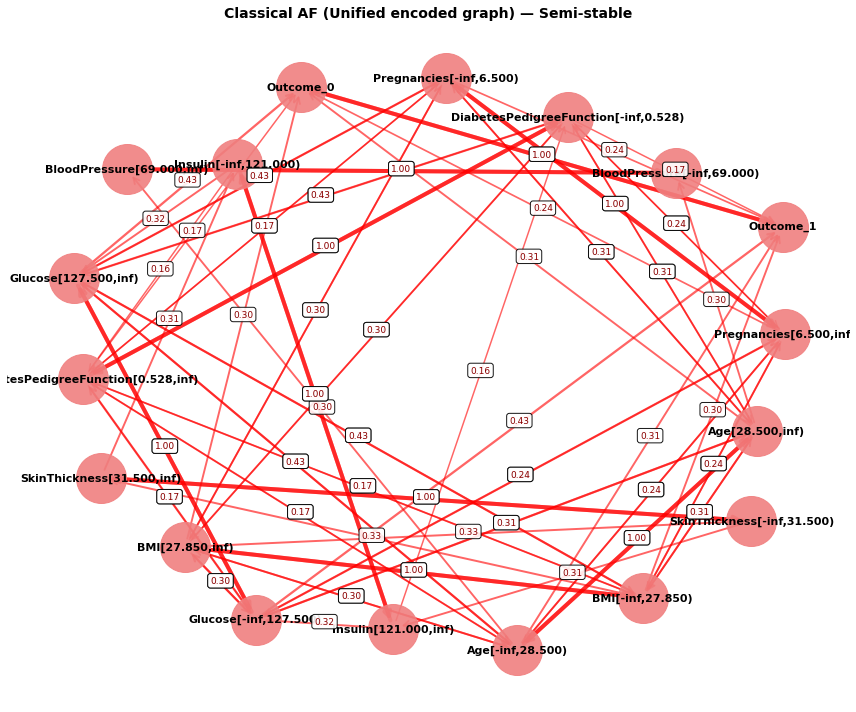

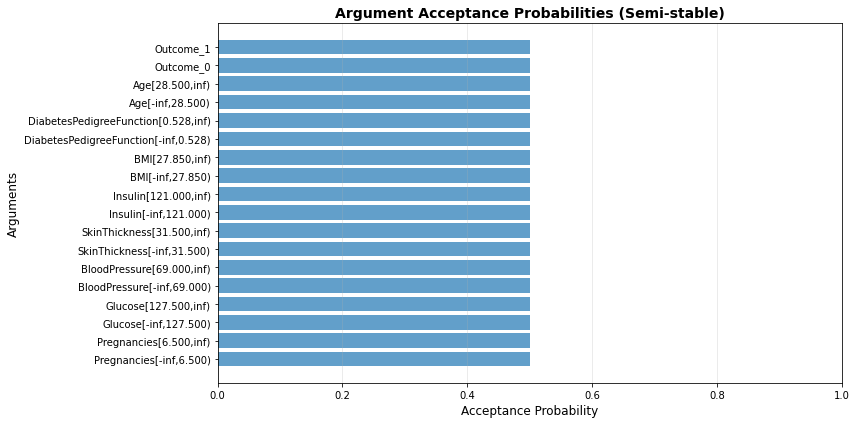

In [ ]:
import seaborn as sns
import os
import pandas as pd


OUTPUT_DIR = "outputs_diabetes/fci_experiment"
os.makedirs(OUTPUT_DIR, exist_ok=True)


df = pd.read_csv("diabetes.csv")
features = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]
outcome = 'Outcome'
categorical_features = []  


entropy_binning_config = {
    "features": features,
    "max_bins": 2,
    "min_gain": 0.01,
    "min_bin_size": 50
}

algo = "fci"    # or "pc"
alpha = 0.05

print("=" * 60)
print(f"STEP 1: Dual discovery ({algo.upper()}) → merge orientations (majority)")
print("=" * 60)
merged_res, merged_group_edges, dfU, enc_groups_full, run1, run2 = run_dual_and_merge_with_unified(
    df,
    features,
    outcome,
    categorical_features,
    entropy_binning_config=entropy_binning_config,
    binarize_counts="Pregnancies",          
    algo=algo,
    alpha=alpha,
    merge_rule="majority",

)
print(f"Merged group-level edges: {sorted(list(merged_group_edges))}")


export_causallearn_graph_with_corr(
    run1,
    f"{OUTPUT_DIR}/discovery_{algo}_dropfirst_weighted.png"
)
export_causallearn_graph_with_corr(
    run2,
    f"{OUTPUT_DIR}/discovery_{algo}_droplast_weighted.png"
)

export_group_graph_with_corr(
    merged_group_edges,
    dfU,
    enc_groups_full,
    f"{OUTPUT_DIR}/merged_groups_{algo}_weighted.png",
    title="Merged Group Directions (corr = strongest pair)"
)

export_unified_graph_with_corr(
    merged_res,
    f"{OUTPUT_DIR}/final_unified_{algo}_weighted.png",
    title="Final Unified Encoded Graph (with correlations)"
)

print("\n" + "=" * 60)
print("STEP 2: BAF on unified encoded graph (ALL dummies & bins)")
print("=" * 60)
baf = BAF(merged_res)
print(f"BAF: |Args|={len(baf.arguments)}  |Supp|={len(baf.supports)}  |Att|={len(baf.attacks)}")

print("\n" + "=" * 60)
print("STEP 3: Split sink into Outcome_0 and Outcome_1")
print("=" * 60)
# NOTE: sink name must match your outcome column
baf = make_binary_sink(baf, sink='Outcome', zero='Outcome_0', one='Outcome_1')

print("\n" + "=" * 60)
print("STEP 4: BAF → AF")
print("=" * 60)
af = baf.to_classical_af(
    threshold=0.15,
    enforce_exclusivity=True,
    exclusivity_skip=('Outcome',),   
    exclusivity_weight=1.0
)
af.print_summary()

print("\n" + "=" * 60)
print("STEP 5: Semi-stable probabilistic extensions")
print("=" * 60)
# drop only the original outcome group (we just split it)
enc_groups_no_outcome = {g: cols for g, cols in enc_groups_full.items() if g != 'Outcome'}

extension_probs = af.compute_extensions_probability(
    semantics='semistable',
    top_k=25,
    threshold=0.20,
    require_one_of=('Outcome_0', 'Outcome_1'),
    enforce_group_exclusivity=True,
    encoding_groups=enc_groups_no_outcome,
    gen_top_m=20,
    gen_force_sampling=True
)


print("\n" + "=" * 60)
print("STEP 6: Argument acceptance")
print("=" * 60)
arg_acceptance = af.analyze_argument_acceptance(extension_probs)

print("\n" + "=" * 60)
print("STEP 7: Visualize & export")
print("=" * 60)
af.visualize(
    title="Classical AF (Unified encoded graph) — Semi-stable",
    output_file=f"{OUTPUT_DIR}/classical_af.png"
)
af.to_apx_format(f"{OUTPUT_DIR}/framework.apx")
af.to_tgf_format(f"{OUTPUT_DIR}/framework.tgf")


plt.figure(figsize=(12, 6))
args_sorted = sorted(arg_acceptance.items(), key=lambda x: -x[1])
args_names = [a for a, _ in args_sorted]
args_probs = [p for _, p in args_sorted]
plt.barh(args_names, args_probs, alpha=0.7)
plt.xlabel('Acceptance Probability', fontsize=12)
plt.ylabel('Arguments', fontsize=12)
plt.title('Argument Acceptance Probabilities (Semi-stable)', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/argument_acceptance.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/argument_acceptance.png")